### G27
Dave Brunner

In [15]:
import math

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Device is set to: {device}")

cuda is available and set


### Loading Data

In [17]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [18]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [19]:
print(len(training_data), len(validation_data), len(test_data))

50000 10000 10000


### Exercise 2: Fixed MLP with Increasing Training Dataset

Create a MLP with one hidden layer with 200 units for Fashion MNIST classification. Use ReLU activation.

Use a random fraction of the training set (split above) to perform the training. Always use the same validation set.

Use SGD and cross-entropy loss and suitable learning rate.

Start with a single small batch for training (batch size 8) and make sure that you can overfit, i.e. bring the training accuracy to 100%.

Then, gradually increase the training set. Let it grow until you obtain values for the training and the validation loss which no longer indicate overfitting. Use a fixed batch size (batchsize 32).

#### MLP Class

In [20]:
def mlp(units=[28 * 28, 200, 10]):
    class MLP(nn.Module):
        def __init__(self):
            super(MLP, self).__init__()
            self.initialize_layers()

        def initialize_layers(self):
            if len(units) == 3:
                self.sequential = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(units[0], units[1]),
                    nn.ReLU(),
                    nn.Linear(units[1], units[2])
                )
            elif len(units) == 4:
                self.sequential = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(units[0], units[1]),
                    nn.ReLU(),
                    nn.Linear(units[1], units[2]),
                    nn.ReLU(),
                    nn.Linear(units[2], units[3])
                )
            elif len(units) == 5:
                self.sequential = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(units[0], units[1]),
                    nn.ReLU(),
                    nn.Linear(units[1], units[2]),
                    nn.ReLU(),
                    nn.Linear(units[2], units[3]),
                    nn.ReLU(),
                    nn.Linear(units[3], units[4])
                )

        def forward(self, x):
            return self.sequential(x)

    return MLP().cuda()

In [21]:
# create an instance and its summary

model = mlp([28 * 28, 200, 300, 400, 10])
from torchsummary import summary

# summary(model, (1, 28, 28))

#### Training Loop 

In [22]:
def train_eval(model, lr, nepochs, nbatch, training_data, validation_data, verbose=True):
    cost_hist = []
    cost_hist_validation = []
    acc_hist = []
    acc_hist_validation = []

    cost_fn = torch.nn.CrossEntropyLoss()
    train_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    train_loader_all_samples = DataLoader(training_data, batch_size=len(training_data), shuffle=True)
    val_loader = DataLoader(validation_data, batch_size=len(validation_data), shuffle=True)
    # Transfer data to GPU
    train_loader = [(data.to(device), target.to(device)) for data, target in train_loader]
    train_loader_all_samples = [(data.to(device), target.to(device)) for data, target in train_loader_all_samples]
    val_loader = [(data.to(device), target.to(device)) for data, target in val_loader]
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    if verbose:
        print(f"Batch size: {nbatch}")
        print(f"Size of train set: {len(training_data)}")
        print(f"Size of validation set: {len(validation_data)}")
        print("Start training.... ->")
        print("--------------------------------------")

    for epoch in range(nepochs):
        for batch_idx, (train_x, train_y) in enumerate(train_loader):
            pred_train = model(train_x)
            loss = cost_fn(pred_train, train_y)

            # update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            # train metrics
            for (train_X_all, train_Y_all) in train_loader_all_samples:
                pred_train = model(train_X_all)
                loss = cost_fn(pred_train, train_Y_all)
                acc_train = (pred_train.argmax(1).eq(train_Y_all)).type(torch.float).sum().item() / (len(train_Y_all))
                cost_hist.append(loss.item())
                acc_hist.append(acc_train)

            # validation metrics
            for (val_x, val_y) in val_loader:
                pred_val = model(val_x)
                loss_val = cost_fn(pred_val, val_y)
                cost_hist_validation.append(loss_val.item())
                acc_val = (pred_val.argmax(1).eq(val_y)).type(torch.float).sum().item() / (len(val_y))
                acc_hist_validation.append(acc_val)
        if verbose:
            print(f"Epoch: {epoch + 1}")
            print(f"Train:      Accuracy={acc_hist[-1]:.4f}, Cost: {cost_hist[-1]:.4f}")
            print(f"Validation: Accuracy={acc_hist_validation[-1]:.4f}, Cost: {cost_hist_validation[-1]:.4f}")
            print("--------------------------------------")
    if not verbose:
        print(f"Final Validation Accuracy={acc_hist_validation[-1]:.4f} Cost: {cost_hist_validation[-1]:.4f}")
        print(f"Final Training   Accuracy={acc_hist[-1]:.4f} Cost: {cost_hist[-1]:.4f}")
    return cost_hist, cost_hist_validation, acc_hist, acc_hist_validation

In [23]:
def train_plot_scores(fun, params_list: list):
    cost_train, cost_valid, acc_train, acc_valid = fun(*params_list)
    plt.figure(1)
    plt.plot(range(nepochs), acc_train, "b-", label="Training acc")
    plt.plot(range(nepochs), acc_valid, "r-", label="Validating acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.figure(2)
    plt.plot(range(nepochs), cost_train, "b-", label="Training cost")
    plt.plot(range(nepochs), cost_valid, "r-", label="Validating cost")
    plt.title("Training and validation cost")
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.legend()


#### First Training

Run a first training with only one small training batch (e.g. with a single batch of 64 samples). 
The small training set can be created by using the functionality `torch.utils.data.random_split` already used above. As validation set use the `validation_data` created above.  

This training run can be used to test whether the model and training loop are properly implemented. Explain why and in what sense it can be used as test.

This is something you can always do when training a model.

Batch size: 32
Size of train set: 32
Size of validation set: 10000
Start training.... ->
--------------------------------------
Epoch: 1
Train:      Accuracy=0.3438, Cost: 2.2079
Validation: Accuracy=0.1741, Cost: 2.2743
--------------------------------------
Epoch: 2
Train:      Accuracy=0.3438, Cost: 2.1130
Validation: Accuracy=0.1590, Cost: 2.2444
--------------------------------------
Epoch: 3
Train:      Accuracy=0.3438, Cost: 2.0328
Validation: Accuracy=0.1460, Cost: 2.2233
--------------------------------------
Epoch: 4
Train:      Accuracy=0.3438, Cost: 1.9588
Validation: Accuracy=0.1385, Cost: 2.2065
--------------------------------------
Epoch: 5
Train:      Accuracy=0.4062, Cost: 1.8897
Validation: Accuracy=0.1563, Cost: 2.1888
--------------------------------------
Epoch: 6
Train:      Accuracy=0.4375, Cost: 1.8250
Validation: Accuracy=0.1926, Cost: 2.1699
--------------------------------------
Epoch: 7
Train:      Accuracy=0.5625, Cost: 1.7613
Validation: Accuracy=0.2388, 

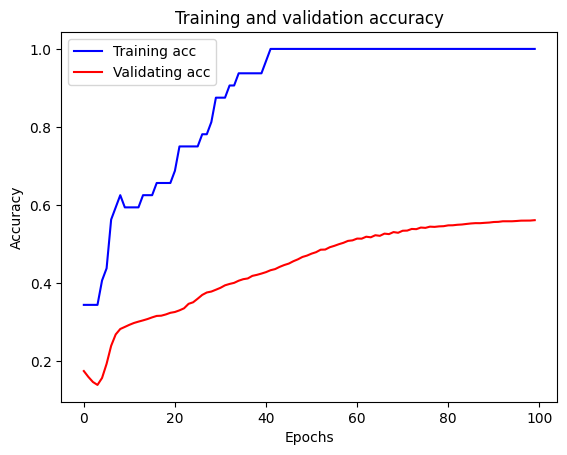

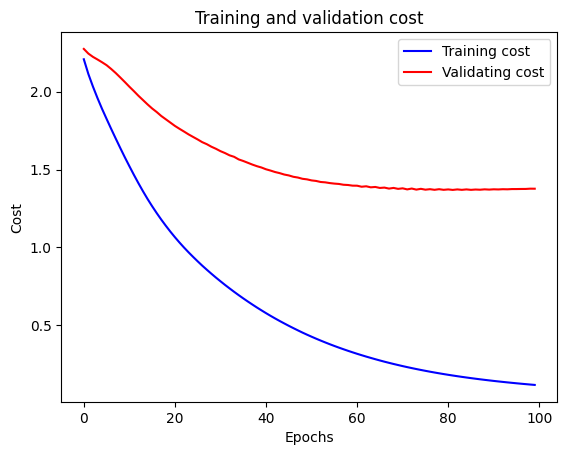

In [24]:
nbatch = 32
nbatches = 1
nepochs = 100
lr = 0.1

trainsize = nbatches * nbatch
trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000 - trainsize])

model = mlp([28 * 28, 200, 10])
train_plot_scores(train_eval, [model, lr, nepochs, nbatch, trainset, validation_data])

#### Evaluate Train and Validation Performance 

Now run several trainings with the same small model (one hidden layer) and explore for different number of training samples (different number of batches with 32 samples) used, how the train and validation performance evolve (cost and accuracy). Make sure that you train sufficiently long to obtain representative values for cost and accuracy with the given settings. Always use the same validation set (with 10'000 samples).

Create plots with training and validation performance vs number of training batches (one for cost and one for accuracy). Use the performance characteristics obtained at the end.

Discuss the whether there is a sufficient number of training samples for the given problem at hand. Specify a minimum number if applicable. Also consider whether you are in the underfitting regime.

Hint: Specify a list with the number of training batches you would like to perform trainings. Try to be economic with the resources used - try to keep the number of trainings limited.

Training set size: 1600
Final Validation Accuracy=0.7771 Cost: 0.7823
Final Training   Accuracy=0.9225 Cost: 0.2340


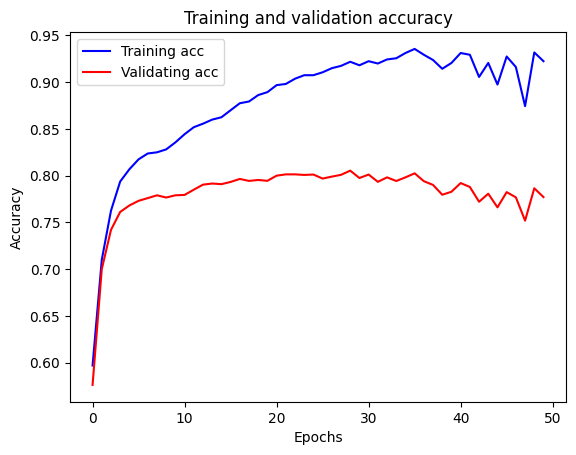

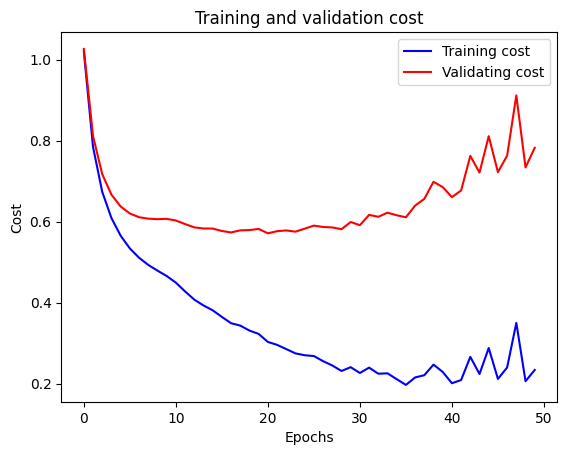

In [25]:
nbatch = 32
nbatches = 50
nepochs = 50
lr = 0.1

trainsize = nbatches * nbatch
trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000 - trainsize])

model = mlp([28 * 28, 200, 10])
print(f"Training set size: {len(trainset)}")
train_plot_scores(train_eval, [model, lr, nepochs, nbatch, trainset, validation_data, False])

Training set size: 3200
Final Validation Accuracy=0.8337 Cost: 0.6625
Final Training   Accuracy=0.9681 Cost: 0.0993


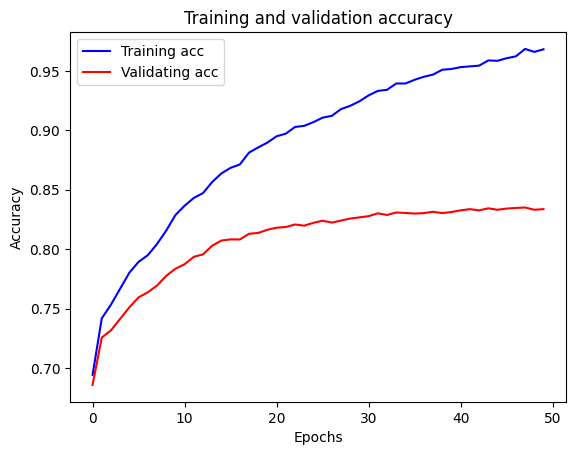

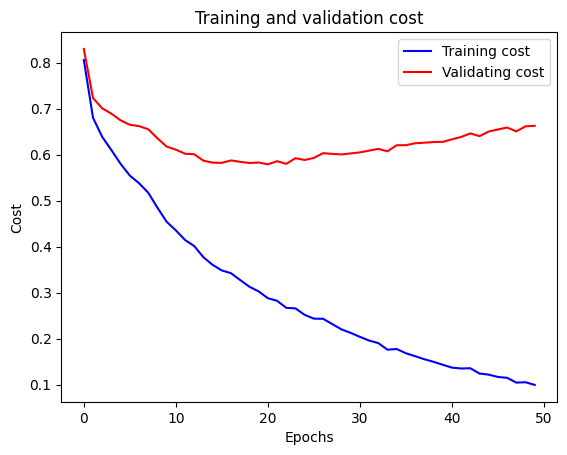

In [26]:
nbatch = 32
nbatches = 100

trainsize = nbatches * nbatch
trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000 - trainsize])

model = mlp([28 * 28, 200, 10])
print(f"Training set size: {len(trainset)}")
train_plot_scores(train_eval, [model, lr, nepochs, nbatch, trainset, validation_data, False])

Training set size: 3200
Final Validation Accuracy=0.8328 Cost: 0.5847
Final Training   Accuracy=0.9613 Cost: 0.1153


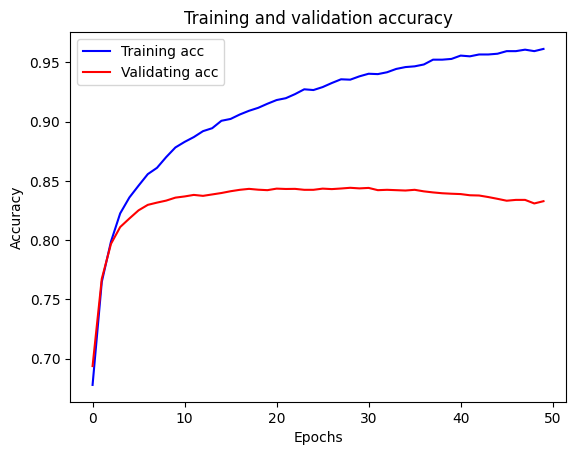

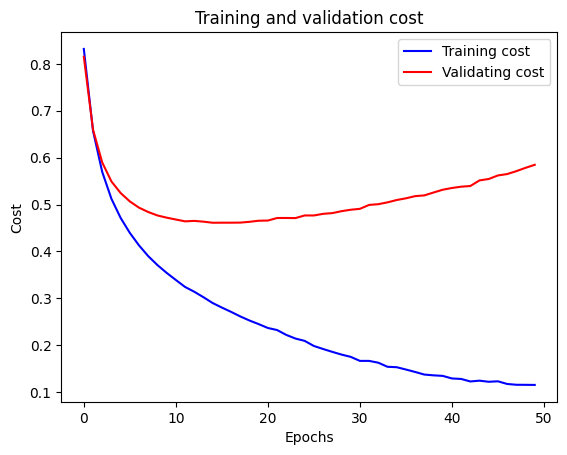

In [27]:
nbatch = 32
nbatches = 100

trainsize = nbatches * nbatch
trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000 - trainsize])

model = mlp([28 * 28, 200, 10])
print(f"Training set size: {len(trainset)}")
train_plot_scores(train_eval, [model, lr, nepochs, nbatch, trainset, validation_data, False])

#### Comments: YOUR comments
With a small train dataset of 1600 samples its easy to have a good accuracy in a short time with low loss on the trainset. After around 5 epochs the model still learns more about the trainset and performance increases on the trainset. On the validation set its a different story. After the 5 epochs the accuracy on the validation set stays on the same level. Because there are so few training samples the model generiles really bad and does not increase performance on the training set.
When increasing the train-size (but still not much) a similar behavior can be seen, but it takes more epoch, till the performance on the unseen data stagnates.

### Exercise 3: Evaluate Different Model Complexities

Use the same functionality implemented above (create MLP model, train and evaluate model) to evaluate different model complexities: Number of layers and number of units per layer.

Start with the small model used in Exercise 2. Then gradually increase the model complexity. Do this along two dimensions:
* a single hidden layer, but increasing the number of units.
* a fixed number of units per (hidden) layer, but increase the number of layers.
Make sure that you reach the overfitting regime (in either case).

Always use the full training set with 50'000 samples.

Again make sure that you train sufficiently long so that the obtained train and validation performance measures (cost, accuracy) are representative.

Create plots with training and validation performance (cost, accuracy) vs model complexity - one plot with number of units for the single hidden layer case, and one for varying number of layers. 

Again use the performance characteristics obtained at the end. 

Finally, discuss your findings.

Training set size: 50000
Single hidden layer size: 300
Final Validation Accuracy=0.8804 Cost: 0.6744
Final Training   Accuracy=0.9492 Cost: 0.1871


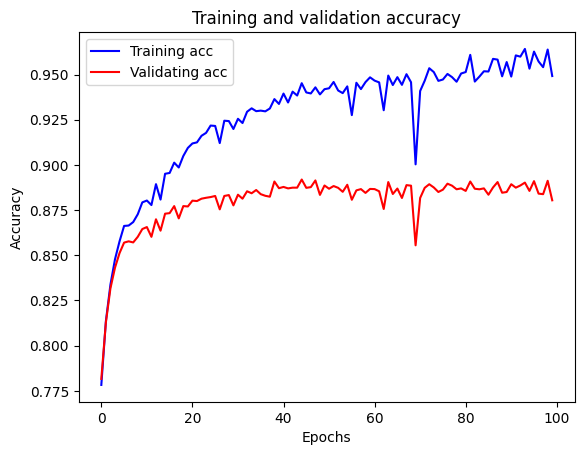

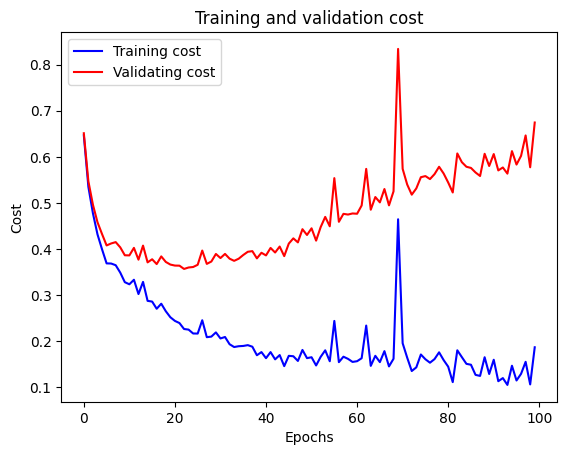

In [28]:
nepochs = 100
nbatch = 32
lr = 0.1

model = mlp([28 * 28, 300, 10])
print(f"Training set size: {len(training_data)}")
print(f"Single hidden layer size: 300")
train_plot_scores(train_eval, [model, lr, nepochs, nbatch, training_data, validation_data, False])

Single hidden layer size: 350
Final Validation Accuracy=0.8892 Cost: 0.6580
Final Training   Accuracy=0.9650 Cost: 0.1088


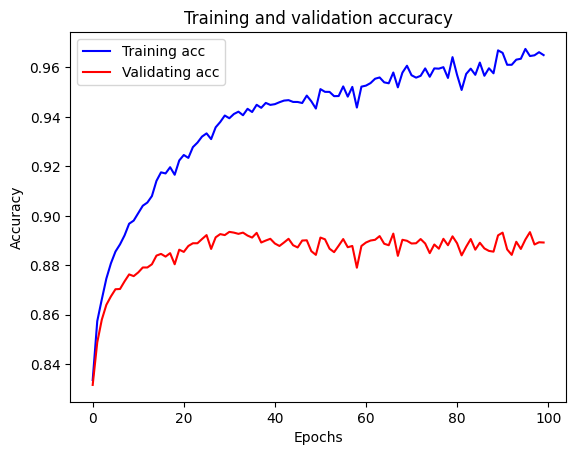

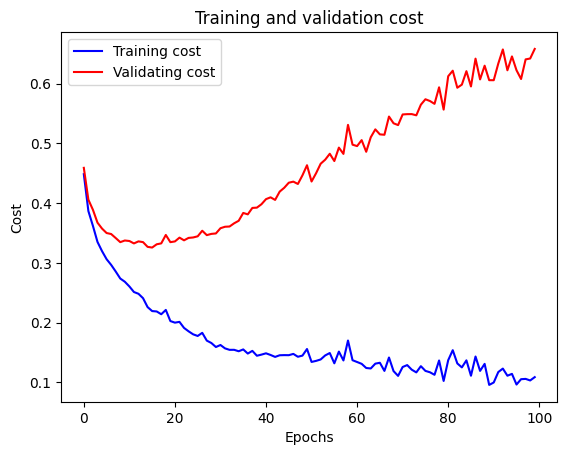

In [29]:
model = mlp([28 * 28, 350, 10])
print(f"Single hidden layer size: 350")
train_plot_scores(train_eval, [model, lr, nepochs, nbatch, training_data, validation_data, False])

Single hidden layer size: 400
Final Validation Accuracy=0.8823 Cost: 0.6850
Final Training   Accuracy=0.9586 Cost: 0.1283


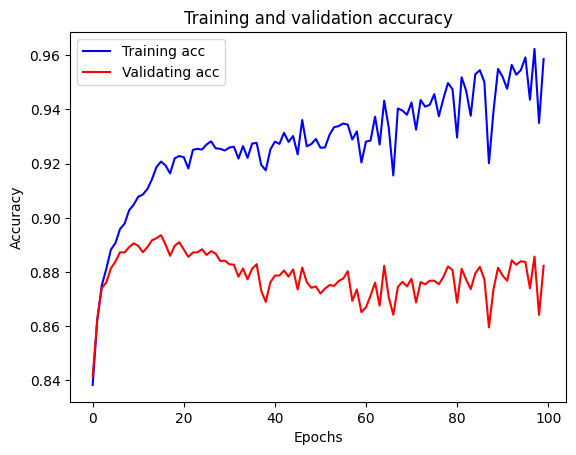

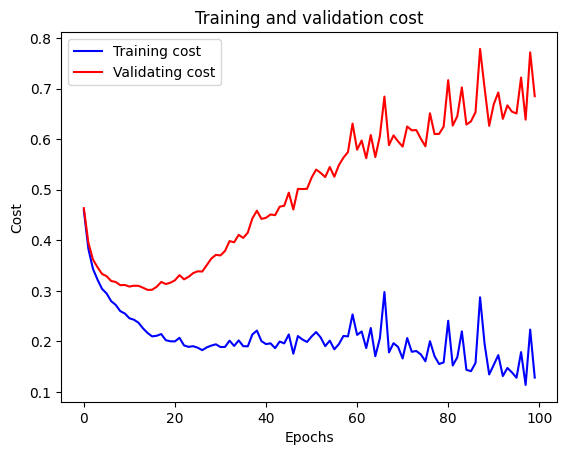

In [30]:
model = mlp([28 * 28, 400, 10])
print(f"Single hidden layer size: 400")
train_plot_scores(train_eval, [model, lr, nepochs, nbatch, training_data, validation_data, False])

Two hidden layers with size: 200
Final Validation Accuracy=0.8794 Cost: 0.9289
Final Training   Accuracy=0.9479 Cost: 0.2281


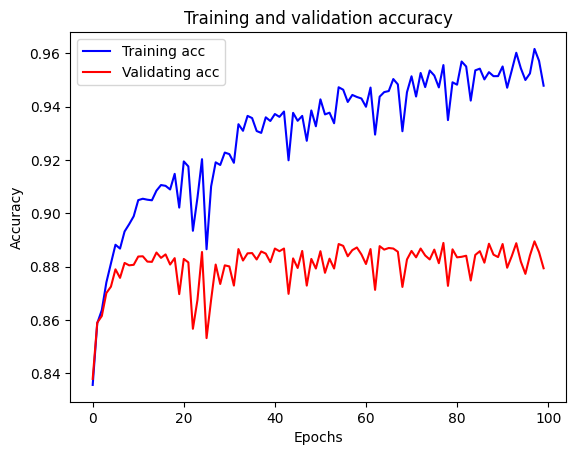

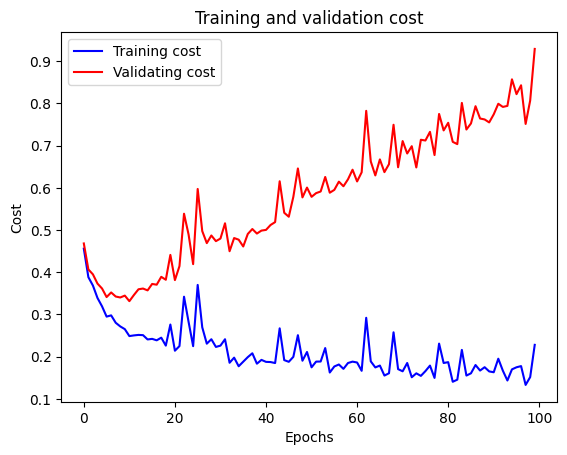

In [31]:
model = mlp([28 * 28, 200, 200, 10])
print(f"Two hidden layers with size: 200")
train_plot_scores(train_eval, [model, lr, nepochs, nbatch, training_data, validation_data, False])

Three hidden layers with size: 200
Final Validation Accuracy=0.8809 Cost: 0.8091
Final Training   Accuracy=0.9507 Cost: 0.1891


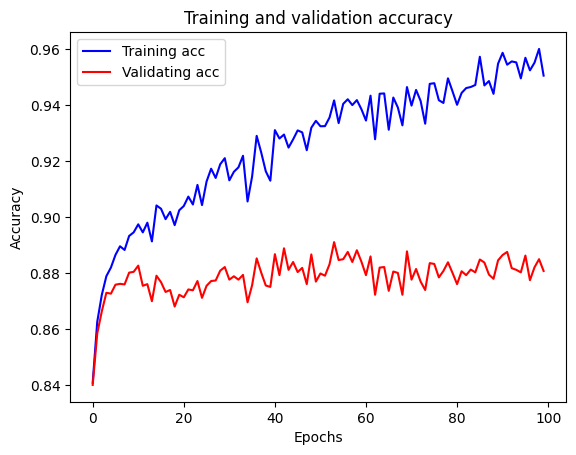

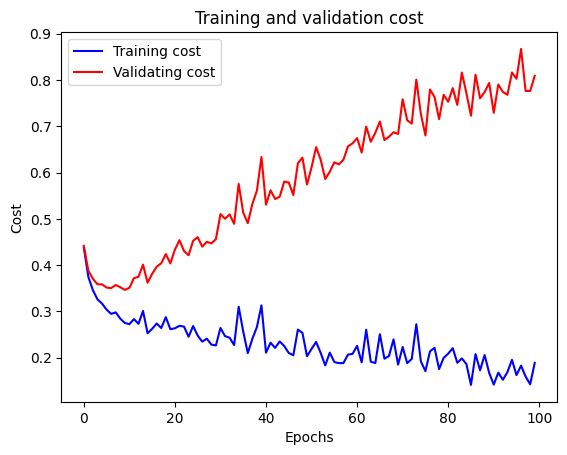

In [32]:
model = mlp([28 * 28, 200, 200, 200, 10])
print(f"Three hidden layers with size: 200")
train_plot_scores(train_eval, [model, lr, nepochs, nbatch, training_data, validation_data, False])

### Findings
With the higher complexity of the NN the capacity to learn increases and therefore it manages to reach higher training accuracies. The validation accuracy increases till a certain epoch afterwards it does not increase anymore,
When increasing the neurons to 300, 350 in the one hidden layer the complexity of the model increased and it manages to have a slightly higher accuracy both on the validation set.

With more than one single layer, the complexity increases substantially and is much more destined to overfit.
Its really interesting to see that the loss on the validation set decreases and starts increasing again after certain epochs. This is due to the overfitting to the training-set.



### Exercise 4: Add Regularisation

Finally, add regularisation - dropout or L1/L2-regularisation. 

To this end, you need to implement new functionality to instantiate the model.

Start with one of the overfitting cases of Exercise 3 and try to improve the validation performance by adding regularisation. You can use either dropout or L1/L2-regularisation.


In [35]:
# define a method that provides an instance of an MLP incl regularisation which uses as a list of units per layer as input 

def mlp_dropout(units=[28 * 28, 200, 10], p_in=0.2, p_hidden=0.5):
    class MLP_dropout(nn.Module):
        def __init__(self):
            super(MLP_dropout, self).__init__()
            self.initialize_layers()

        def initialize_layers(self):
            if len(units) == 3:
                self.sequential = nn.Sequential(
                    nn.Flatten(),
                    nn.Dropout(p=p_in),
                    nn.Linear(units[0], units[1], ),
                    nn.ReLU(),
                    nn.Dropout(p=p_hidden),
                    nn.Linear(units[1], units[2])
                )

        def forward(self, x):
            return self.sequential(x)

    return MLP_dropout().cuda()



In [36]:
model = mlp_dropout([28 * 28, 200, 10])

from torchsummary import summary

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 200]         157,000
              ReLU-4                  [-1, 200]               0
           Dropout-5                  [-1, 200]               0
            Linear-6                   [-1, 10]           2,010
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.61
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


#### Playing with different complexities and regularisation

Now play with different complexities and regularisation. 
Start with one of the overfitting cases identified in the previous exercise.
By adding regularisation, you should be able to make it non-overfitting, i.e. generalising better.
Note that for a given complexity, adding regularisation reduces the model capacity. This may need to be compensated by increasing the complexity of the model. 

Use again cost and accuracy for train and validation set to evaluate the results.

Finally, estimate the bias error and the generalisation error. 

Single hidden layer size: 400
Final Validation Accuracy=0.8672 Cost: 0.3887
Final Training   Accuracy=0.8924 Cost: 0.2794


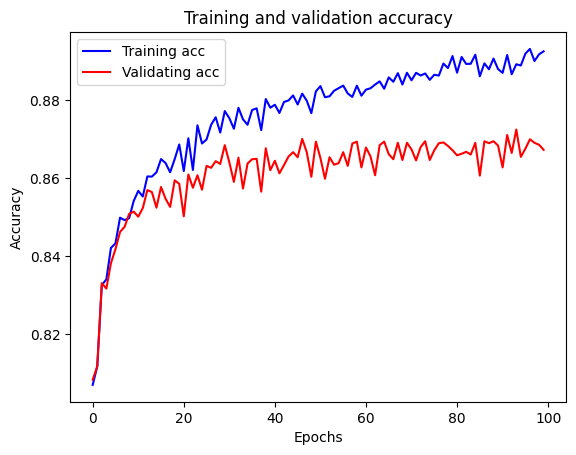

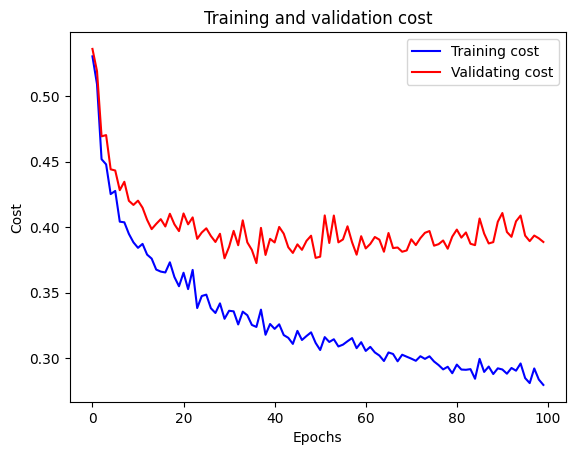

In [37]:
nepochs = 100
nbatch = 32
lr = 0.1
model = mlp_dropout([28 * 28, 400, 10])
print(f"Single hidden layer size: 400")
train_plot_scores(train_eval, [model, lr, nepochs, nbatch, training_data, validation_data, False])

When comparing the model with regularization and compare it to the same model without regularization it's to be expected that it would perform better on new unseen data. The bias error of the regularization_model is actually a bit higher when comparing the accuracy on the validation dataset.